# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="VisualBanana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
State shape: (1, 84, 84, 3)
States look like:


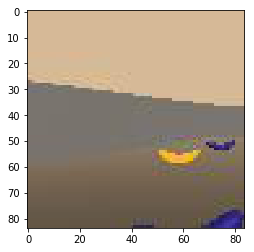

States have shape: (1, 84, 84, 3)


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('State shape:', state.shape)
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        basic_channels = 64
        n_residual = 1
        
        self.input_layer = nn.Conv2d(3, basic_channels, 3, padding=1)
        
        # residual modules:
        self.res_net = nn.ModuleList()
        # layers decreasing spatial dimension and increasing channels 
        self.deepen_layer = nn.ModuleList()
        
        for i in range(n_residual):
            n_channels = 2**i * basic_channels
            bn1 = nn.BatchNorm2d(n_channels)
            conv1 = nn.Conv2d(n_channels, n_channels, 3, padding=1)
            bn_conv1 = nn.ModuleList([bn1, conv1])
            bn2 = nn.BatchNorm2d(n_channels)
            conv2 = nn.Conv2d(n_channels, n_channels, 3, padding=1)
            bn_conv2 = nn.ModuleList([bn2, conv2])
            res = nn.ModuleList([bn_conv1, bn_conv2])
            self.res_net.append(res)
        
            bn = nn.BatchNorm2d(n_channels)
            conv = nn.Conv2d(n_channels, 2 * n_channels, 3, stride=2, padding=1)
            bn_conv = nn.ModuleList([bn, conv])
            self.deepen_layer.append(bn_conv)
        
        self.fc = nn.Linear(2**n_residual * basic_channels, 4)
        
    def forward(self, x):
        x = self.input_layer(x)
        for i, res in enumerate(self.res_net):
            y = x
            for bn_conv in res:
                bn, conv = bn_conv
                y = bn(y)
                y = F.relu(y)
                y = conv(y)
            x = x + y
            
            bn, conv = self.deepen_layer[i]
            x = bn(x)
            x = F.relu(y)
            x = conv(x)
        # flatten
        x = x.mean(2).mean(2)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        
        return x

In [28]:
from collections import deque, namedtuple
import random

class ReplayBuffer():
    def __init__(self, sample_size, buffer_size=int(1e4)):
        self.buffer = deque(maxlen=buffer_size)
        self.sample_size = sample_size
        self.experience = namedtuple('experience', field_names=('state', 'action', 'reward', 'next_state', 'done'))
        
    def add(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state, done)
        self.buffer.append(exp)
        
    def sample(self):
        experiences = random.sample(self.buffer, self.sample_size)
        
        # divide into batches
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

In [29]:
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, alpha=1e-3, gamma=0.99, epsilon=0.1, tau=1e-3, action_size=action_size, batch_size=4):
        self.Q = DQN().to(device)
        self.Q_target = deepcopy(self.Q).to(device)
        self.buffer = ReplayBuffer(sample_size=batch_size)
        self.t = 0
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = tau
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr=self.alpha)
    
    def transpose(self, state):
        # convert HWC to CHW
        state = np.transpose(state, (0, 3, 1, 2))
        
        return state
    
    def act(self, state):
        state = self.transpose(state)
        state = torch.from_numpy(state).float().to(device)
        self.Q.eval()
        with torch.no_grad():
            action_values = self.Q(state)
        self.Q.train()
        
        if random.random() < self.epsilon:
            return random.choice(range(self.action_size))
        else:
            return np.argmax(action_values.cpu().numpy())
        
    def step(self, state, action, reward, next_state, done):
        state = self.transpose(state)
        next_state = self.transpose(next_state)
        self.buffer.add(state, action, reward, next_state, done)
        
        self.t += 1
        if self.t > 100 + self.buffer.sample_size:
            experiences = self.buffer.sample()
            self._update_net(experiences)
            
    def _update_net(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        targets = rewards + (1 - dones) * self.gamma * self.Q_target(next_states).detach().max(1)[0].reshape((-1, 1))
        predictions = self.Q(states).gather(1, actions)
        
        loss = F.mse_loss(predictions, targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self._moving_average()
    
    def _moving_average(self):
        for target_param, param in zip(self.Q_target.parameters(), self.Q.parameters()):
            target_param.data.copy_((1 - self.tau) * target_param.data + self.tau * param.data)

In [ ]:
agent = Agent()
for i in range(int(1e2)):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.visual_observations[0]
    score = 0 
    while True:
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.visual_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    
    print("Episode {} Score: {}".format(i, score))

torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.

torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([4, 128, 42, 42])
torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([4, 128, 42, 42])
torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([4, 128, 42, 42])
torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([4, 128, 42, 42])
torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([4, 128, 42, 42])
torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([4, 128, 42, 42])
torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([4, 128, 42, 42])
torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([4, 128, 42, 42])
torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([1, 128, 42, 42])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([4, 128, 42, 42])
torch.Size([4, 128])
torch.Size([4, 128])
torch.

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```